In [83]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [84]:
n_variate = 1

In [85]:

#Load dataset
def load_dataset(path=r'usa_dataset.csv'):
  return pd.read_csv(path)

In [86]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [87]:
#preparing the data for the LSTM
def prepare_data(df):
        #retirar a primeira row porque tem valores nulos
        df_raw = df.drop([0])
        #Get pair to evaluate for time series
        #We are going to predict the opening value for each day
        df_raw["Start Date"] = pd.to_datetime(df_raw["Start Date"])
        df_raw = df_raw.sort_values("Start Date")
        df_raw = df_raw.set_index('Start Date')
        df_raw = df_raw.reindex(columns=['Influenza Deaths', 'COVID-19 Deaths', 'Total Deaths', 'Percent of Expected Deaths',
            'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 
            'Pneumonia, Influenza, or COVID-19 Deaths', 'flights',
            'commercial_flights', 'People Screened at Airports',
            'US International Commercial Flights', 'Nr People staying home',
            'Nr People not staying home', 'Nr of trips', 'Max_Temp', 'Min_Temp',
            'Temperature', 'Precipitation', 'Wind_Speed', 'Wind_Direction',
            'Visibility', 'Cloud_Cover', 'Relative_Humidity', 'Rain', 'Clear',
            'Partially_cloudy'])
        # drop de features com correlação alta a outras
        df_raw = df_raw.drop(columns=['COVID-19 Deaths', 'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths',
                                'Pneumonia, Influenza, or COVID-19 Deaths', 'Nr People staying home', 'Max_Temp', 'Min_Temp'])
        # fazer drop das colunas descartadas pelo feature selection
        df_raw = df_raw.drop(columns=['Total Deaths', 'Percent of Expected Deaths', 
                            'Wind_Direction', 'Visibility', 'Cloud_Cover', 'Rain', 'Clear', 'Partially_cloudy'])
        # df_data = df_data.drop(columns=['Wind_Direction', 'Rain', 'Clear', 'Partially_cloudy'])
        return df_raw

In [88]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [89]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'Influenza Deaths']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['Influenza Deaths']] = scaler.fit_transform(df[['Influenza Deaths']])
    
    return scaler

In [90]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.plot(epochs_range,mae,label='Training MAE')
  plt.plot(epochs_range,val_mae,label='Validation MAE')
  plt.plot(epochs_range,rmse,label='Training RMSE')
  plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [91]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [92]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
      # y.append(data[input_index:label_index, 0:n_variate])

  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [93]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [94]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  # model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
  return model

In [95]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [96]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

['flights', 'commercial_flights', 'People Screened at Airports', 'US International Commercial Flights', 'Nr People not staying home', 'Nr of trips', 'Temperature', 'Precipitation', 'Wind_Speed', 'Relative_Humidity']


In [97]:
df

,Influenza Deaths,flights,commercial_flights,People Screened at Airports,US International Commercial Flights,Nr People not staying home,Nr of trips,Temperature,Precipitation,Wind_Speed,Relative_Humidity
Start Date,,,,,,,,,,,
2020-01-05,0.447328,0.749663,0.951798,0.831021,1.000000,0.459184,0.013177,-0.479326,-0.611408,-0.085580,0.413697
2020-01-12,0.425954,0.909002,0.997583,0.840934,0.890926,0.725768,0.403617,-0.491577,-0.658336,0.728840,0.164375
2020-01-19,0.523664,0.912888,0.995482,0.806662,0.888520,0.726122,0.456634,-0.613068,-0.874939,0.434169,0.392255
2020-01-26,0.468702,1.000000,1.000000,0.751426,0.876271,0.723109,0.429653,-0.833589,-0.388415,-0.310345,0.036460
2020-02-02,0.590840,0.886318,0.892010,0.752024,0.821589,0.804184,0.439682,-0.674324,-0.961972,-0.192790,0.101485
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,-0.978626,0.653435,0.037358,-0.035992,-0.217819,0.416729,0.584489,-0.680449,-0.812212,0.528213,-0.710653
2021-03-14,-0.990840,0.570119,0.081574,0.097074,-0.206883,0.552753,0.653199,-0.134252,-1.000000,0.448276,-1.000000
2021-03-21,-0.978626,0.588240,0.117816,0.155823,-0.208122,0.675161,0.680005,-0.497703,-0.815152,0.119122,-0.219501


In [98]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    # se for necessário prever mais do que 1 semana
    # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    # print('list_yhat:')
    # print(list_yhat)
    # #preparar novo input para fazer previsão para a semana seguinte
    # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
    # print('forecasts:')
    # print(forecasts)
  return forecasts



In [99]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(20,8))
  plt.plot(range(len(data)), data['Influenza Deaths'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Influenza Deaths in USA')
  plt.ylabel('Number of Deaths')
  plt.xlabel('Weeks')
  plt.legend()
  plt.show()

# Tunning

In [100]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 2 },
                # 2: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 3: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 },

                #
                # 4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                # 5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }
# record da history de cada modelo
record = {}

Epoch 1/25
7/7 [==============================] - 4s 150ms/step - loss: 0.7310 - mae: 0.7226 - rmse: 0.7310 - val_loss: 0.8179 - val_mae: 0.8108 - val_rmse: 0.8179
Epoch 2/25
7/7 [==============================] - 0s 14ms/step - loss: 0.5664 - mae: 0.5543 - rmse: 0.5664 - val_loss: 0.5822 - val_mae: 0.5633 - val_rmse: 0.5822
Epoch 3/25
7/7 [==============================] - 0s 17ms/step - loss: 0.3984 - mae: 0.3704 - rmse: 0.3984 - val_loss: 0.2865 - val_mae: 0.2457 - val_rmse: 0.2865
Epoch 4/25
7/7 [==============================] - 0s 15ms/step - loss: 0.2752 - mae: 0.2510 - rmse: 0.2752 - val_loss: 0.0768 - val_mae: 0.0645 - val_rmse: 0.0768
Epoch 5/25
7/7 [==============================] - 0s 16ms/step - loss: 0.1966 - mae: 0.1812 - rmse: 0.1966 - val_loss: 0.0803 - val_mae: 0.0679 - val_rmse: 0.0803
Epoch 6/25
7/7 [==============================] - 0s 15ms/step - loss: 0.1858 - mae: 0.1671 - rmse: 0.1858 - val_loss: 0.1413 - val_mae: 0.1355 - val_rmse: 0.1413
Epoch 7/25
7/7 [=====

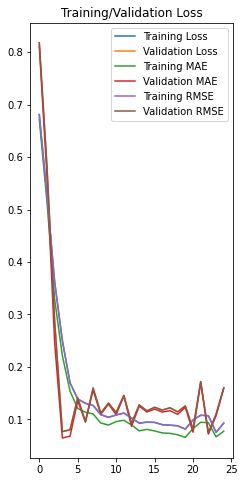

Epoch 1/25
14/14 [==============================] - 3s 71ms/step - loss: 0.1552 - mae: 0.1477 - rmse: 0.1638 - val_loss: 0.5525 - val_mae: 0.5477 - val_rmse: 0.5525
Epoch 2/25
14/14 [==============================] - 0s 12ms/step - loss: 0.2037 - mae: 0.1962 - rmse: 0.2044 - val_loss: 0.3666 - val_mae: 0.3628 - val_rmse: 0.3666
Epoch 3/25
14/14 [==============================] - 0s 12ms/step - loss: 0.0961 - mae: 0.0870 - rmse: 0.0939 - val_loss: 0.1166 - val_mae: 0.1112 - val_rmse: 0.1166
Epoch 4/25
14/14 [==============================] - 0s 12ms/step - loss: 0.0981 - mae: 0.0867 - rmse: 0.0982 - val_loss: 0.1792 - val_mae: 0.1678 - val_rmse: 0.1792
Epoch 5/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0715 - mae: 0.0603 - rmse: 0.0707 - val_loss: 0.1057 - val_mae: 0.0959 - val_rmse: 0.1057
Epoch 6/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0584 - mae: 0.0478 - rmse: 0.0572 - val_loss: 0.0961 - val_mae: 0.0922 - val_rmse: 0.0961
Epoch 7/25

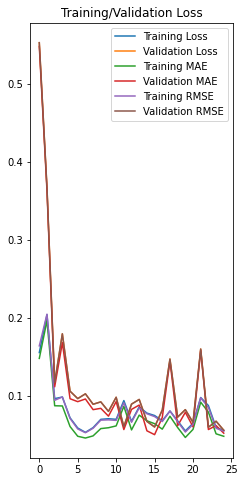

Epoch 1/25
20/20 [==============================] - 0s 15ms/step - loss: 0.0552 - mae: 0.0500 - rmse: 0.0548 - val_loss: 0.0659 - val_mae: 0.0610 - val_rmse: 0.0659
Epoch 2/25
20/20 [==============================] - 0s 11ms/step - loss: 0.0744 - mae: 0.0681 - rmse: 0.0736 - val_loss: 0.0827 - val_mae: 0.0779 - val_rmse: 0.0827
Epoch 3/25
20/20 [==============================] - 0s 11ms/step - loss: 0.0959 - mae: 0.0878 - rmse: 0.0945 - val_loss: 0.0888 - val_mae: 0.0806 - val_rmse: 0.0888
Epoch 4/25
20/20 [==============================] - 0s 11ms/step - loss: 0.0628 - mae: 0.0559 - rmse: 0.0618 - val_loss: 0.0822 - val_mae: 0.0770 - val_rmse: 0.0822
Epoch 5/25
20/20 [==============================] - 0s 12ms/step - loss: 0.0809 - mae: 0.0737 - rmse: 0.0799 - val_loss: 0.1112 - val_mae: 0.1085 - val_rmse: 0.1112
Epoch 6/25
20/20 [==============================] - 0s 11ms/step - loss: 0.1372 - mae: 0.1281 - rmse: 0.1361 - val_loss: 0.0469 - val_mae: 0.0393 - val_rmse: 0.0469
Epoch 7/25

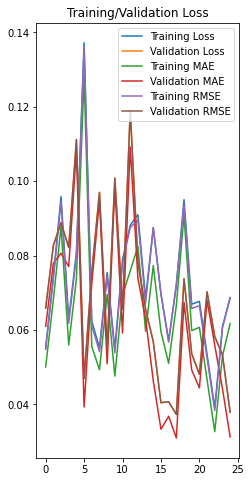

[array([[247.9291 , 234.4664 , 246.19173, 261.7581 , 248.39426, 254.57056,
        268.73843, 253.49004, 254.01607, 261.57047, 252.076  ]],
      dtype=float32)]
Previsões:
[247.9291]


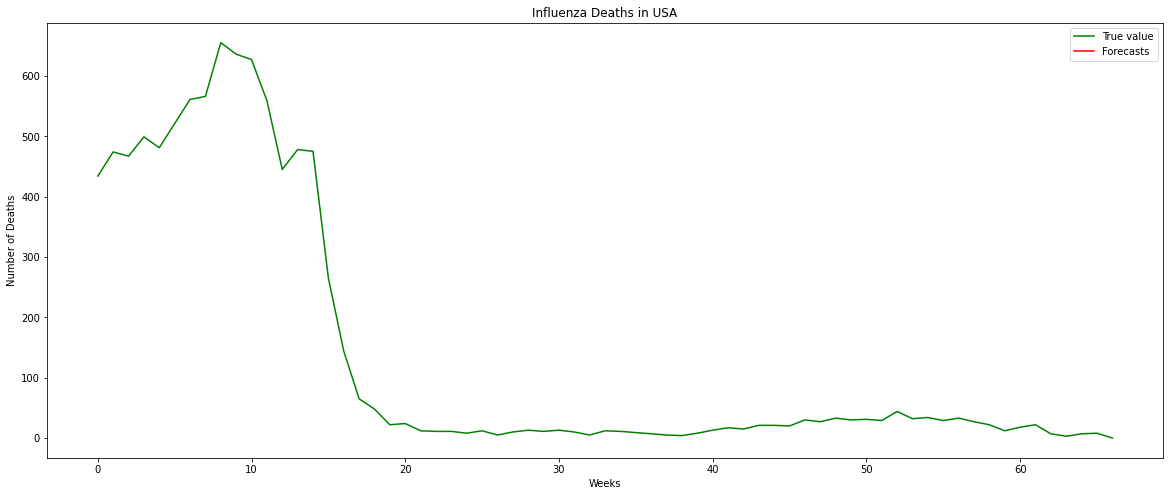

In [101]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print('Previsões:')
  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [102]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [103]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.10522022018829981, 0.09437121997276943, 0.10471025496721269, 0.1203156474729379, 0.11438903344174227, 0.1203156474729379] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.10522,0.094371,0.10471,0.120316,0.114389,0.120316
